# Pz estimation from images 

In [1]:
import tensorflow as tf

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2023-05-15 06:31:05.193072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 06:31:06.426278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2023-05-15 06:31:06.440010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data preprocessing

In [4]:
%ls /global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp


download  img_30k.npy  z_30k.npy


In [5]:
data = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

In [6]:
type(data)

numpy.lib.npyio.NpzFile

In [7]:
data.files

['labels', 'cube']

### Labels

In [8]:
cat = pd.DataFrame(data["labels"][:20000] )
cat.columns

Index(['imageID', 'specObjID', 'bestObjID', 'class', 'subClass', 'z', 'zErr',
       'objID', 'type', 'flags', 'ra', 'dec', 'l', 'b', 'dered_petro_u',
       'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i',
       'petroMagErr_z', 'zphot', 'dzphot', 'zphot_avg', 'zphot_reliable',
       'e_bv_sfd', 'primtarget', 'sectarget', 'targettype', 'spectrotype',
       'Column1', 'v_disp', 'release', 'bptclass', 'lgm_tot_p50',
       'sfr_tot_p50', 'specsfr_tot_p50', 'oh_p50', 'logMass_median',
       'ssfr_mean', 'age_mean', 'tau_mean', 't_age_mean', 'metallicity_mean',
       'dust1_mean', 'dust2_mean', 'EBV', 'fracDev_r', 'deVAB_r', 'deVPhi_r',
       'expAB_r', 'expPhi_r', 'petroR90_r', 'deVRad_r', 'expRad_r',
       'probPSF_r', 'extinction_u', 'extinction_g', 'extinction_r',
       'extinction_i', 'extinction_z'],
      dtype='object')

In [9]:
z = cat.z

Les redshift sont relativement faibles dans cette base de données: 0 < z < 0.7

In [10]:
cat.z.min(), cat.z.max()

(0.00018725298, 0.6729151)

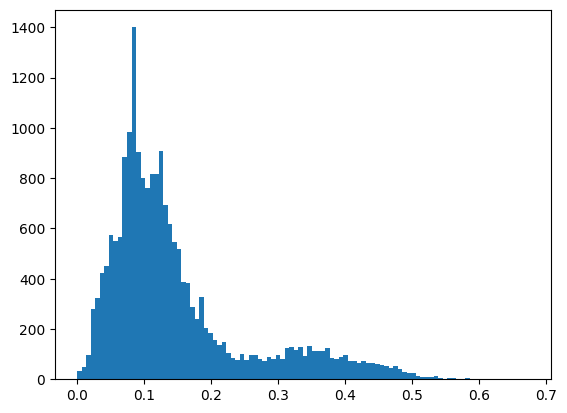

In [11]:
plt.hist(cat.z, bins=100);

### Cube

In [12]:
images = data['cube'][:20000]

In [13]:
images.shape

(20000, 64, 64, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


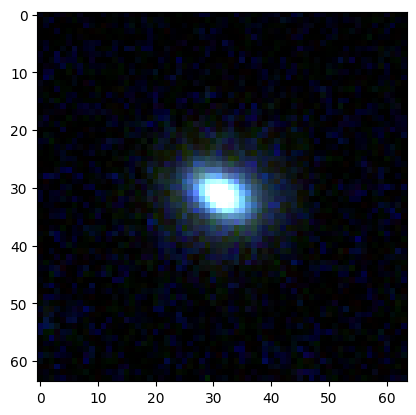

In [14]:
plt.imshow(images[0, :, :,2:5])
plt.show();

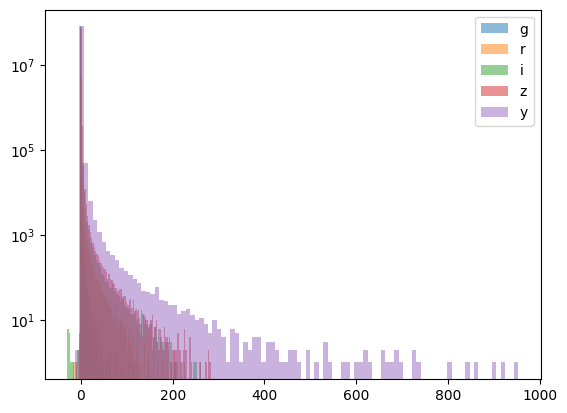

In [15]:
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(images[...,i].flatten(), 100, label=b, alpha=0.5)
    plt.yscale('log');
    plt.legend()

Need to standardize the data

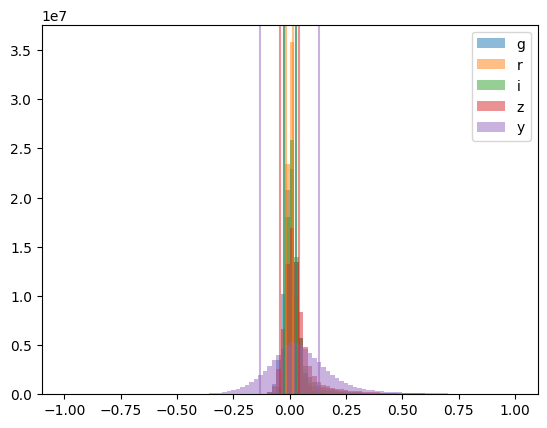

In [16]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
from astropy.stats import mad_std
scaling = []
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(images[...,i].flatten(), 100, label=b, alpha=0.5, range=[-1,1]);
    sigma = mad_std(images[...,i].flatten())
    scaling.append(sigma)
    plt.axvline(sigma, color='C%d'%i,alpha=0.5)
    plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
    plt.legend()

In [17]:
scaling

[0.027201450308288307,
 0.015744658158159067,
 0.026313249176732202,
 0.04233410217981075,
 0.13110988674491722]

In [18]:
from sklearn.preprocessing import StandardScaler
scaling_std = []
scaler = StandardScaler(with_mean=False)
img = scaler.fit_transform(np.reshape(images, (20000*64*64, 5)))
print(scaler.var_)

[0.00767485 0.07113803 0.20978536 0.34144495 0.83912806]


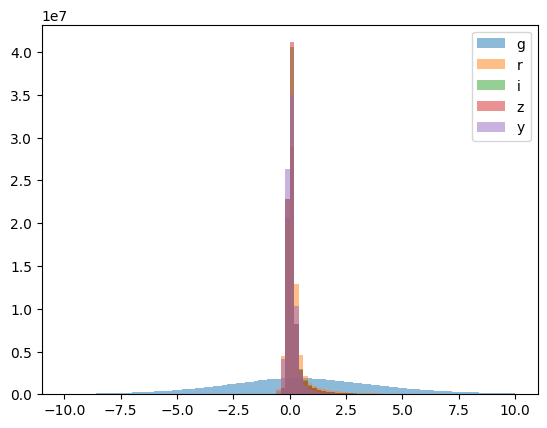

In [19]:
# Let's have a look at this distribution if we rescale each band by the standard deviation
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(images[...,i].flatten()/scaler.var_[i],100, label=b,alpha=0.5, range=[-10,10]);
    plt.legend()

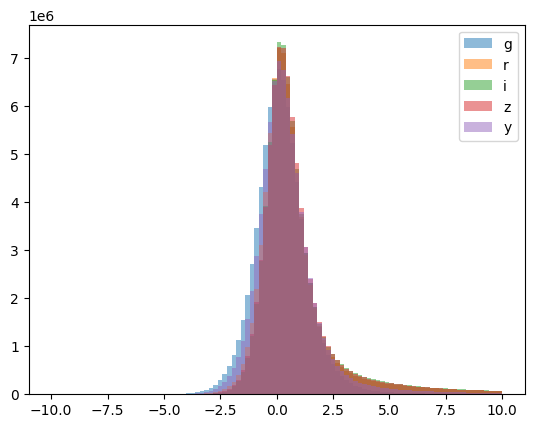

In [20]:
# Let's have a look at this distribution if we rescale each band by the standard deviation
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(images[...,i].flatten()/scaling[i],100, label=b,alpha=0.5, range=[-10,10]);
    plt.legend()

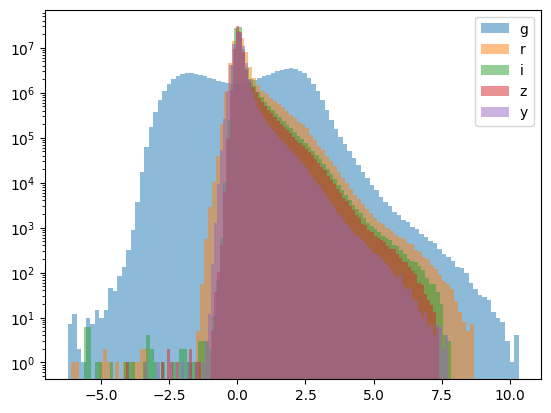

In [21]:
# a common approach for range compression is to apply arcsinh to suppress the high amplitude values
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(np.arcsinh(images[...,i].flatten()/scaler.var_[i]),100,label=b, alpha=0.5);
plt.legend()
plt.yscale('log')

In [22]:
def preprocessing(image):
    return np.arcsinh(image / scaling / 3. )

In [23]:
prepro_img = preprocessing(images)

2023-05-15 06:49:56.823336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


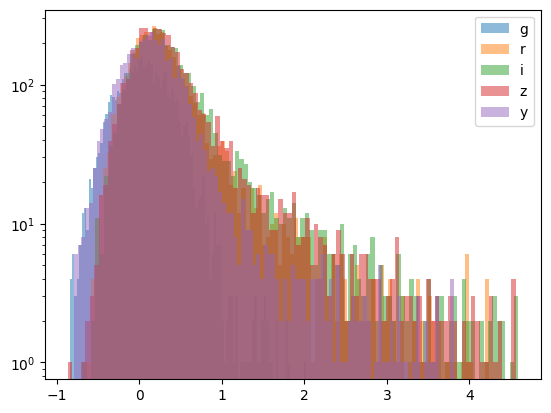

In [24]:
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(tf.reshape(prepro_img[1000, :, :,i], -1), 100, label=b, alpha=0.5)
    plt.yscale('log');
plt.legend()

### Train test split 

In [25]:
# Split into train and test taking 10,000 samples each
img_train = prepro_img[:10000,...]
img_test = prepro_img[10000:, ...]

z_train = z[:10000]
z_test = z[10000:]

In [26]:
img_train.shape

(10000, 64, 64, 5)

# 2. CNN model

In [27]:
import tensorflow.keras as tfk

def create_model():
    model = tfk.models.Sequential()
    
    model.add(tfk.layers.Conv2D(32, kernel_size=5, padding='same', input_shape=(64,64,5), activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())

    model.add(tfk.layers.Conv2D(64, kernel_size=3, padding='same', activation='elu'))
    model.add(tfk.layers.BatchNormalization())

    model.add(tfk.layers.Conv2D(128, kernel_size=3, padding='same', strides=2, activation='elu'))
    model.add(tfk.layers.BatchNormalization())  

    model.add(tfk.layers.Conv2D(256, kernel_size=3, padding='same', activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())

    model.add(tfk.layers.Conv2D(512, kernel_size=3, padding='same', activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    
    # remplacer flatten par global pooling potentiellment moins d'overfit
    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dense(1024))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(1024))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(1))

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.mse)
    return model

In [28]:
model = create_model()

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        4032      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 128)      5

In [30]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tfk.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/CNN', update_freq='batch')

model.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_test, z_test),
          steps_per_epoch=10000//64,
          epochs=40,
          callbacks=[lr_decay])

Epoch 1/40


2023-05-15 06:50:06.162133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-05-15 06:50:08.506020: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


156/156 [==============================] - 8s 21ms/step - loss: 6.8977 - val_loss: 0.0077 - lr: 0.0010
Epoch 2/40
156/156 [==============================] - 1s 9ms/step - loss: 0.0082 - val_loss: 0.0051 - lr: 9.0000e-04
Epoch 3/40
156/156 [==============================] - 2s 10ms/step - loss: 0.0088 - val_loss: 0.0050 - lr: 8.1000e-04
Epoch 4/40
156/156 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0041 - lr: 7.2900e-04
Epoch 5/40
156/156 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0035 - lr: 6.5610e-04
Epoch 6/40
156/156 [==============================] - 2s 12ms/step - loss: 0.0012 - val_loss: 0.0037 - lr: 5.9049e-04
Epoch 7/40
156/156 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0037 - lr: 5.3144e-04
Epoch 8/40
156/156 [==============================] - 1s 9ms/step - loss: 7.4762e-04 - val_loss: 0.0034 - lr: 4.7830e-04
Epoch 9/40
156/156 [==============================] - 1s 9ms/step - loss

In [31]:
# Get the prediction
preds = model.predict(img_test)

313/313 [==============================] - 1s 2ms/step


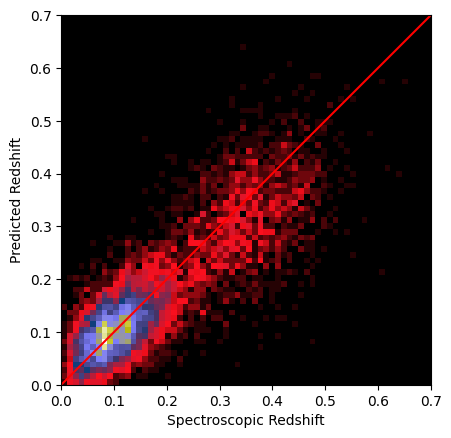

In [32]:
plt.hist2d(z_test, preds.squeeze(), 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [35]:
from tools import *
dz, pred_bias, smad, out_frac = metrics(z_test, preds.squeeze())


def print_metrics(pred_bias, smad, out_frac):
    print(f'Prediction bias: {pred_bias:.4f}')
    display(Latex(f'$\sigma MAD$: {smad:.4f}'))
    print(f'Outlier fraction: {out_frac*100:.2f}%')
    
print_metrics(pred_bias, smad, out_frac)

Prediction bias: -0.0036


<IPython.core.display.Latex object>

Outlier fraction: 26.64%


# 3. ResNet

In [193]:
from tensorflow.keras.applications import ResNet50

def resnet_model():

    model = tfk.models.Sequential()

    model.add(ResNet50(include_top = False,
                     pooling = 'avg',
                     input_shape=(64,64,5),
                     weights=None))

    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dense(512))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(256))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(1))

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.mse)
    return model

In [194]:
model_resnet = resnet_model()

model_resnet.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23593984  
                                                                 
 flatten_20 (Flatten)        (None, 2048)              0         
                                                                 
 dense_60 (Dense)            (None, 512)               1049088   
                                                                 
 activation_40 (Activation)  (None, 512)               0         
                                                                 
 dense_61 (Dense)            (None, 256)               131328    
                                                                 
 activation_41 (Activation)  (None, 256)               0         
                                                                 
 dense_62 (Dense)            (None, 1)               

In [195]:
%%time
# Learning rate schedule
LEARNING_RATE=0.0001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tfk.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
tb_callback = tf.keras.callbacks.TensorBoard('./logs/ResNet', update_freq='batch')

model_resnet.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_test, z_test),
          steps_per_epoch=10000//64,
          epochs=200,
          callbacks=[tb_callback, lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/200
156/156 [==============================] - 9s 37ms/step - loss: 0.1516 - val_loss: 0.0118 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9e-05.
Epoch 2/200
156/156 [==============================] - 4s 28ms/step - loss: 0.0264 - val_loss: 0.0139 - lr: 9.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 8.1e-05.
Epoch 3/200
156/156 [==============================] - 4s 29ms/step - loss: 0.0145 - val_loss: 0.0086 - lr: 8.1000e-05

Epoch 4: LearningRateScheduler setting learning rate to 7.290000000000001e-05.
Epoch 4/200
156/156 [==============================] - 4s 29ms/step - loss: 0.0123 - val_loss: 0.0112 - lr: 7.2900e-05

Epoch 5: LearningRateScheduler setting learning rate to 6.561e-05.
Epoch 5/200
156/156 [==============================] - 4s 28ms/step - loss: 0.0095 - val_loss: 0.0109 - lr: 6.5610e-05

Epoch 6: LearningRateScheduler setting learning rate to 5.904

In [196]:
# Get the prediction
resnet_preds = model_resnet.predict(img_test)

313/313 [==============================] - 2s 6ms/step


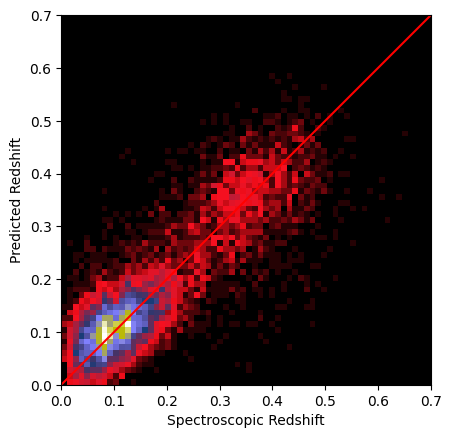

In [197]:
plt.hist2d(z_test, resnet_preds.squeeze(), 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [198]:
dz, pred_bias, smad, out_frac = metrics(z_test, resnet_preds.squeeze())
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0032


<IPython.core.display.Latex object>

Outlier fraction: 25.83%


In [40]:
# Compare MSE results
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(z_test, preds)
mse_resnet = mean_squared_error(z_test, resnet_preds)
print(f"MSE for CNN model: {1e3*mse:.2f} e-3")
print(f'MSE for ResNet50 model: {1e3*mse_resnet:.2f} e-3')
print(mean_absolute_error(z_test, preds), mean_absolute_error(z_test, resnet_preds))

MSE for CNN model: 2.26 e-3
MSE for ResNet50 model: 1.78 e-3
0.032209106 0.028921926


# 4. DenseNet

In [217]:
from tensorflow.keras.applications import DenseNet121

def densenet_model():

    model = tfk.models.Sequential()

    model.add(DenseNet121(include_top = False,
                     pooling = 'avg',
                     input_shape=(64,64,5),
                     weights=None))

    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dense(512))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(256))
    model.add(tfk.layers.Activation('relu'))
    model.add(tfk.layers.Dense(1))

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.mse)
    return model

In [218]:
model_densenet = densenet_model()

model_densenet.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7043776   
                                                                 
 flatten_24 (Flatten)        (None, 1024)              0         
                                                                 
 dense_72 (Dense)            (None, 512)               524800    
                                                                 
 activation_48 (Activation)  (None, 512)               0         
                                                                 
 dense_73 (Dense)            (None, 256)               131328    
                                                                 
 activation_49 (Activation)  (None, 256)               0         
                                                                 
 dense_74 (Dense)            (None, 1)               

In [219]:
%%time
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tfk.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
tb_callback = tf.keras.callbacks.TensorBoard('./logs/DenseNet', update_freq='batch')

model_densenet.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_test, z_test),
          steps_per_epoch=10000//64,
          epochs=40,
          callbacks=[tb_callback, lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/40
156/156 [==============================] - 16s 66ms/step - loss: 0.1906 - val_loss: 0.0098 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/40
156/156 [==============================] - 8s 54ms/step - loss: 0.0026 - val_loss: 0.0033 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/40
156/156 [==============================] - 9s 55ms/step - loss: 0.0022 - val_loss: 0.0025 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/40
156/156 [==============================] - 8s 54ms/step - loss: 0.0021 - val_loss: 0.0026 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/40
156/156 [==============================] - 9s 55ms/step - loss: 0.0021 - val_loss: 0.0017 - lr: 6.5610e-04

Epoch 6: LearningRateSchedul

In [220]:
# Get the prediction
densenet_preds = model_densenet.predict(img_test)

313/313 [==============================] - 5s 12ms/step


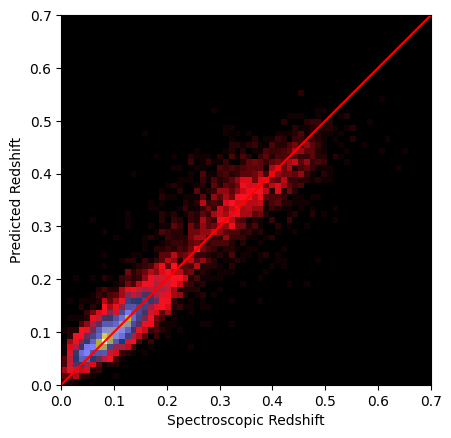

In [221]:
plt.hist2d(z_test, densenet_preds.squeeze(), 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [222]:
dz, pred_bias, smad, out_frac = metrics(z_test, densenet_preds.squeeze())
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0050


<IPython.core.display.Latex object>

Outlier fraction: 8.11%


In [223]:
# Compare MSE results
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(z_test, preds)
mse_densenet = mean_squared_error(z_test, densenet_preds)
print(f"MSE for CNN model: {1e3*mse:.2f} e-3")
print(f'MSE for DenseNet121 model: {1e3*mse_densenet:.2f} e-3')
print(mean_absolute_error(z_test, preds), mean_absolute_error(z_test, densenet_preds))

MSE for CNN model: 1.58 e-3
MSE for DenseNet121 model: 1.33 e-3
0.030199088 0.025328277
